[*********************100%%**********************]  1 of 1 completed
Precio actual: 30564.45, Tendencia: Baja
cuartil 1 : 28490.0712890625
cuartil 3 : 29929.03857421875
Precio promedio:  29234.177074652776
Vender


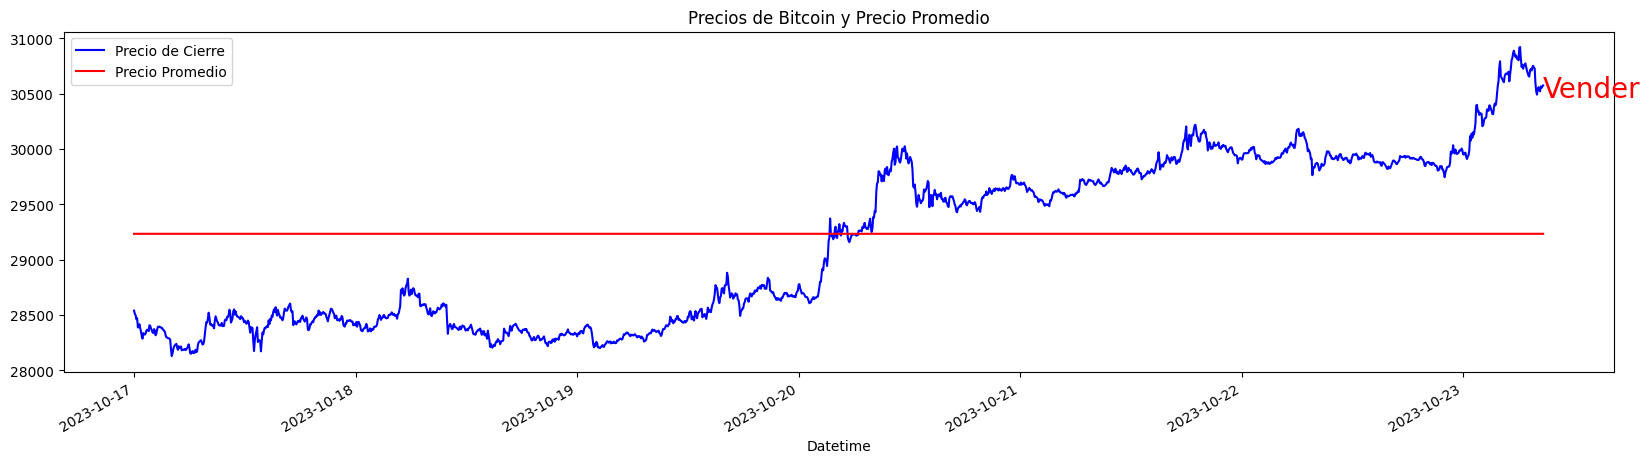

KeyboardInterrupt: ignored

In [2]:
from IPython.display import clear_output
import yfinance as yf
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from lxml import etree
import time,datetime


# Definir variables globales
df_bitcoin =pd.DataFrame()
precio_actual = None
tendencia = None
media_bitcoin = None
variacion = None
algoritmo_decision = None

#Crea una funcion importar_base_bitcoin()
def importar_base_bitcoin():
    #definir variables globales
    global df_bitcoin,precio_actual, tendencia, media_bitcoin, algoritmo_decision

    # Extracción del historial de precios
    data = yf.download(tickers='BTC-USD', period='7d', interval='5m')

    # Crear un DataFrame de pandas
    df_bitcoin = pd.DataFrame(data)

#Crea una funcion extraer_tendencias()
def extraer_tendencias():
    #definir variables globales
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

    # Realizar web scraping
    url = 'https://coinmarketcap.com/'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, features='lxml')

    # Extraer el precio actual del Bitcoin y la variación en la última hora
    btc_price = soup.find('div', class_='sc-a0353bbc-0 gDrtaY').text.strip()
    #btc_change = soup.find('span', class_=['sc-d55c02b-0 iwhBxy', 'sc-d55c02b-0 gUnzUB']).text.strip()
    #clase_tendencia = btc_change.get_attribute("class")

    # Convertir el precio a float
    precio_actual = float(btc_price.replace('$', '').replace(',', ''))

    # Determinar la tendencia en función de la variación

    lista=[]
    tendencia =soup.findAll('span', {'class':['sc-d55c02b-0 iwhBxy' , 'sc-d55c02b-0 gUnzUB']})
    for item in tendencia[::3] :
      lista.append(item)
    for indice in range(len(lista)):
      if lista[indice].find('span')['class'][0] == 'icon-Caret-down':
          tendencia = 'Baja'
      else:
          tendencia= 'Alta'


    print(f"Precio actual: {precio_actual}, Tendencia: {tendencia}")




#Crea una funcion limpieza_datos()
def limpieza_datos():
    #definir variables globales
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

    # Copia de la base original
    df_bitcoin_limpio = df_bitcoin.copy()

    # Eliminación de índices duplicados
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]

    # Tratar valores nulos en la columna Close
    df_bitcoin_limpio['Close'].fillna(method='ffill', inplace=True)

    # Eliminación de registros con Volume <= 0
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

    # Identificación y eliminación de outliers en Close usando boxplot
    Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
    Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
    print("cuartil 1 :", Q1)
    print("cuartil 3 :", Q3)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= lower_bound) & (df_bitcoin_limpio['Close'] <= upper_bound)]

    # Cálculo del precio promedio (Close)
    media_bitcoin = df_bitcoin_limpio['Close'].mean()
    print("Precio promedio: ", media_bitcoin)


# Crea una funcion tomar_decisiones()
def tomar_decisiones():
    #definimos variables globales
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

    # Criterio de decisión
    if (precio_actual >= media_bitcoin) and (tendencia == 'Baja'):
        algoritmo_decision = 'Vender'
    elif (precio_actual < media_bitcoin) and (tendencia == 'Alta'):
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'Esperar'
    print(algoritmo_decision)


#Crea una función visualizacion()
def visualizacion():
    #definimos variables globales
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

       # Adición de columna 'Promedio'
    df_bitcoin['Promedio'] = media_bitcoin

    # Configuración del tamaño del gráfico
    plt.figure(figsize=(20, 5))

    # Adición de título al gráfico
    plt.title('Precios de Bitcoin y Precio Promedio')

    # Dibujar líneas en el gráfico
    df_bitcoin['Close'].plot(label='Precio de Cierre', color='b')
    df_bitcoin['Promedio'].plot(label='Precio Promedio', color='r')

    # Mostrar la decisión en el gráfico
    #plt.annotate(f'{algoritmo_decision}', (df_bitcoin.index[-1], df_bitcoin['Close'].max()), xytext=(0, -20),
    #         textcoords='offset points', fontsize=20, color='red', ha='right', va='top')
    plt.annotate(f'{algoritmo_decision}', (df_bitcoin.index[-1], df_bitcoin['Close'].max()), xytext=(0, -20),
             textcoords='offset points', fontsize=20, color='red', ha='left', va='top')


    # Mostrar el gráfico
    plt.legend(loc='upper left')
    plt.show()


while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)